In [1]:
# This has to go in its own cell or it screws up the defaults we'll set later
%matplotlib inline

In [2]:
import numpy as np
import musictoys.audiofile, musictoys.analysis
from scrapbook import plot

In [3]:
filedata, filerate = musictoys.audiofile.read("audio_files/kronfeld-dreamatic.wav")
#filedata, filerate = musictoys.audiofile.read("audio_files/jfb-back_home.wav")
#filedata, filerate = musictoys.audiofile.read("audio_files/liberty_chaps-get_up_get_down.wav")
samples, samplerate = musictoys.analysis.normalize(filedata, filerate)

In [4]:
frame_size = 1024
step_size = frame_size / 2
step_rate = samplerate / step_size
num_frames = int((len(samples) - frame_size + 1) / step_size)
graph_height = 256
gridx, gridy = np.mgrid[0:num_frames, 0:graph_height]

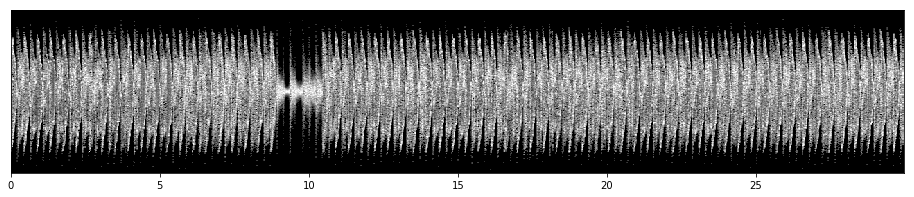

In [5]:
mag2d = np.zeros((num_frames, graph_height))
for i in range(num_frames):
    clip = samples[i*step_size:i*step_size+frame_size]
    hist, bin_edges = np.histogram(clip, bins=graph_height, range=(-1,1))
    mag2d[i] = hist / np.float(hist.max())
# normalize each frame's samples: divide by its max value
# take sqrt to represent power with brightness
power2d = np.sqrt(mag2d)
plot.gram(power2d, x=step_rate)

In [6]:
hann = np.hanning(frame_size)

spectrogram = []
for i in range(num_frames):
    clip = samples[i*step_size:i*step_size+frame_size]
    spectrogram.append(np.fft.rfft(clip * hann)[:frame_size/2])

spectrogram = np.array(spectrogram)
# take absolute value to get magnitude
spectrogram = (np.absolute(spectrogram) * 2.0) / np.sum(hann)
# square to get power
powerspectrogram = np.square(spectrogram)
# convert to decibels, clip noise floor
loudnessgram = (10 * np.log10(powerspectrogram)).clip(-120)
# compute the center frequency of each FFT bin
nyquist_freq = samplerate / 2.0
fft_bin_freq = np.arange(spectrogram.shape[1]) * nyquist_freq / float(spectrogram.shape[1])
half_nyquist = nyquist_freq / 2.0

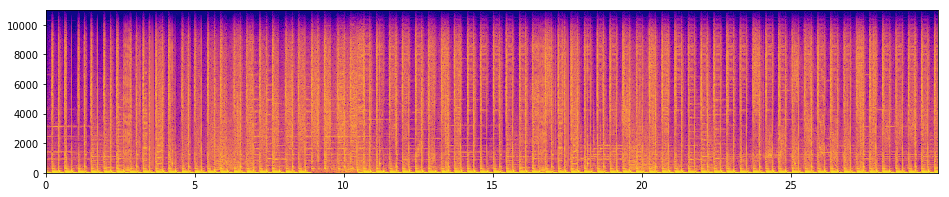

In [7]:
plot.gram(loudnessgram, x=step_rate, y=fft_bin_freq, cmap='plasma')

In [8]:
def spectral_centroid(spectrogram, samplerate):
    # the axes should be ordered [samples, bins]
    num_bins = spectrogram.shape[1]
    bin_idx = np.arange(num_bins, dtype=np.float)
    bin_center_freq = bin_idx * (samplerate / 2.0) / float(num_bins)
    magspec = np.abs(spectrogram)
    weighted_bins = bin_center_freq[np.newaxis,:] * magspec
    return np.sum(weighted_bins, axis=1) / np.sum(magspec, axis=1)

In [9]:
def spectral_spread(spectrogram, samplerate):
    centroid = spectral_centroid(spectrogram, samplerate)
    num_bins = spectrogram.shape[1]
    bin_idx = np.arange(num_bins, dtype=np.float)
    bin_center_freq = bin_idx * (samplerate / 2.0) / float(num_bins)
    variance = np.square(bin_center_freq[np.newaxis,:] - centroid[:,np.newaxis])
    magspec = np.abs(spectrogram)
    numerator = np.sum(variance * magspec, axis=1)
    denominator = np.sum(magspec, axis=1)
    return np.sqrt((numerator * 1.0) / denominator)

In [10]:
def spectral_crest(spectrogram):
    return spectrogram.max(axis=1) / spectrogram.sum(axis=1)

In [11]:
def freq_to_mel(freq):
    return 2595.0 * np.log10(1 + (freq/700.0))

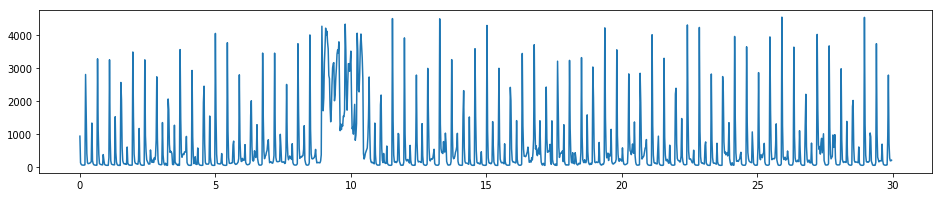

In [12]:
centroids = spectral_centroid(powerspectrogram, samplerate)
plot.line(centroids, x=step_rate)

spread mean == 887.91, std == 808.62, min==29.77, max==3073.34


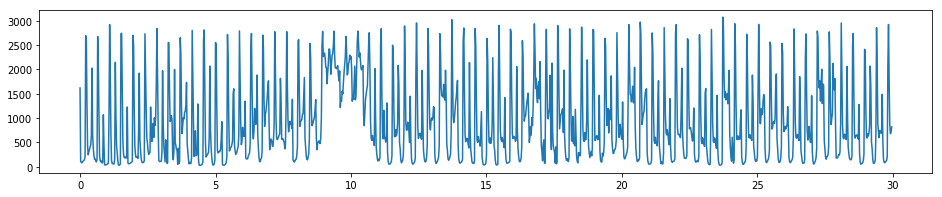

In [13]:
spreads = spectral_spread(powerspectrogram, samplerate)
print "spread mean == %.2f, std == %.2f, min==%.2f, max==%.2f" % (spreads.mean(), spreads.std(), spreads.min(), spreads.max())
plot.line(spreads, x=step_rate)

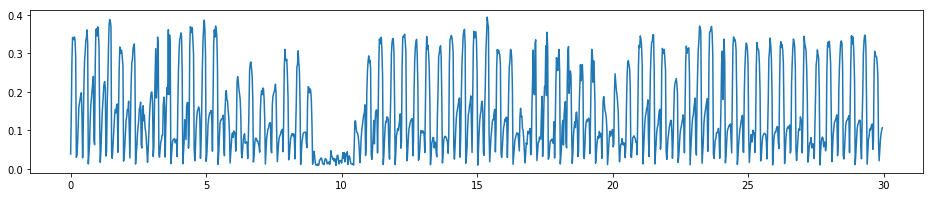

In [14]:
crests = spectral_crest(spectrogram)
plot.line(crests, x=step_rate)

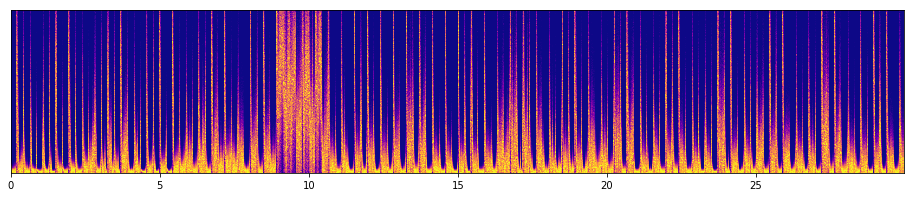

In [28]:
spectrum2d = np.zeros((num_frames, graph_height))
# generate a normal distribution representing centroid & spread
for i in range(num_frames):
    centroid = centroids[i]
    spread = spreads[i]
    distribution = centroid + spread * np.random.randn(10000)
    hist, bin_edges = np.histogram(distribution, bins=graph_height, range=(0,half_nyquist))
    spectrum2d[i] = hist / np.float(hist.max())
plot.gram(spectrum2d, x=step_rate, cmap='plasma')

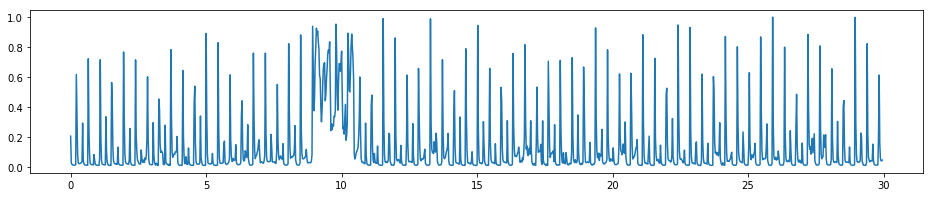

In [30]:
hues = centroids / half_nyquist
hues /= hues.max()
plot.line(hues, x=step_rate)

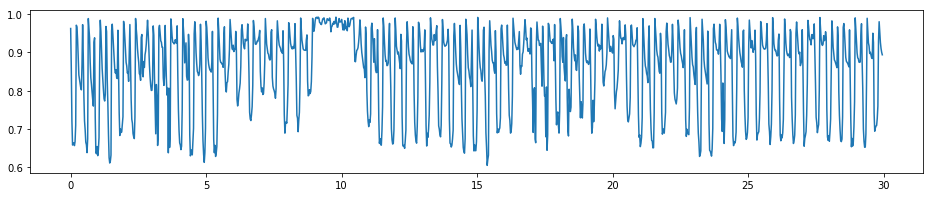

In [31]:
saturations = 1.0 - crests
plot.line(saturations, x=step_rate)
# yes! this is the one

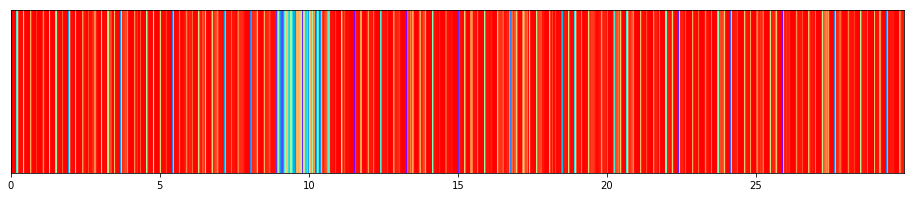

In [32]:
# generate corresponding hue and saturation matrices
hue2d = hues[gridx]
plot.gram(hue2d, x=step_rate, cmap='rainbow_r')

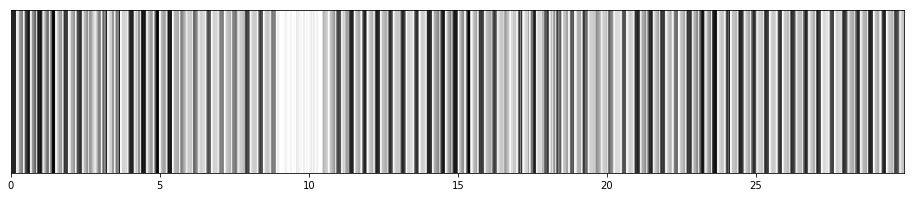

In [33]:
sat2d = saturations[gridx]
plot.gram(sat2d, x=step_rate)

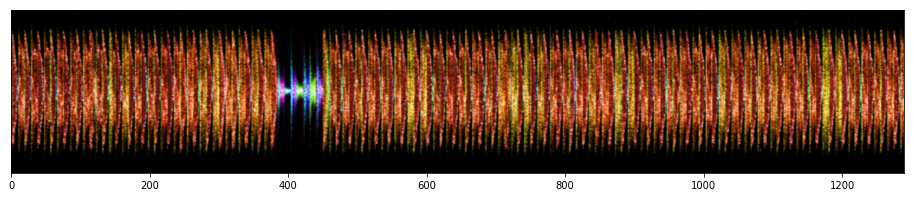

In [34]:
def hsl_to_rgb(h, s, l):
    shape = h.shape
    
    # all inputs and outputs range 0..1
    r = np.zeros(shape)
    g = np.zeros(shape)
    b = np.zeros(shape)
    
    # where the color is totally desaturated, use only luminance
    grey = (s==0)
    r[grey] = l[grey]
    g[grey] = l[grey]
    b[grey] = l[grey]
    
    # scale the saturation differently around medium luminance
    q = np.zeros(shape)
    low_luma = l < 0.5
    q[low_luma] = l[low_luma] * (1 + s[low_luma])
    hi_luma = l >= 0.5
    q[hi_luma] = l[hi_luma] + s[hi_luma] - l[hi_luma] * s[hi_luma]
    # the other hue factor is proportional
    p = 2 * l - q;
    
    def channel(t):
        # enforce limits
        t[t < 0] += 1.0
        t[t > 1] -= 1.0
        x = np.zeros(shape)
        tA = t < 1/6.
        x[tA] = p[tA] + (q[tA] - p[tA]) * 6 * t[tA] 
        tB = (t >= 1/6.) & (t < 1/2.)
        x[tB] = q[tB]
        tC = (t >= 1/2.) & (t < 2/3.)
        x[tC] = p[tC] + (q[tC] - p[tC]) * (2/3. - t[tC]) * 6
        tD = t >= 2/3.
        x[tD] = p[tD]
        return x

    chroma = (s != 0)
    r[chroma] = channel(h + 1./3.)[chroma]
    g[chroma] = channel(h)[chroma]
    b[chroma] = channel(h - 1./3.)[chroma]

    return r, g, b

r2d, g2d, b2d = hsl_to_rgb(hue2d, sat2d, mag2d)
image_rgb = np.stack((r2d, g2d, b2d), axis=2)
plot.colorgram(image_rgb, x=step_rate)
